In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:

class Self_Attention(nn.Module):
    """
    #Self-AttentionのLayer
    """
    def __init__(self,in_dim):
        super(Self_Attention,self).__init__()#不明
        #i*1の畳み込み層によるpointwise convolutionを用意
        self.query_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim//8,kernel_size=1)#Conv2dを生成画像サイズ確認
        self.key_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim//8,kernel_size=1)#Conv2dを生成
        self.value_conv=nn.Conv2d(
            in_channels=in_dim,out_channels=in_dim,kernel_size=1)#Conv2dを生成)
        #AttentionMap用の正規化softmax
        self.softmax=nn.Softmax(dim=-2)
        #入力xとAttentionMapを足すときの係数
        self.gamma=nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        #入力
        X=x
        #畳み込みをしてからサイズ変更B,C',W,H->B,C',N
        proj_query=self.query_conv(x).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C',N
        proj_query=proj_query.permute(0,2,1)#転置#サイズ　B,N,C'
        proj_key=self.key_conv(x).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C',N
        #かけざん
        S=torch.bmm(proj_query,proj_key)#サイズB,N,N
        
        #規格化
        attention_map_T=self.softmax(S)#正規化
        attention_map=attention_map_T.permute(0,2,1)#サイズ:B,N,N(?)#出力しないから転置不要
        #Attentionmapを計算
        proj_value=self.value_conv(X).view(
            X.shape[0],-1,X.shape[2]*X.shape[3])#サイズB,C,N
        #o=torch.bmm(proj_value,attention_map_T.permute)
        o=torch.bmm(proj_value,attention_map.permute(0,2,1))#出力しないから転置不要
        
        #AttentionmapのoのテンソルサイズをXにそろえる->計算
        o=o.view(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
        out=x+self.gamma*o
        return out #,attention_map#attention_mapは学習には不要

In [3]:
# Generator
# Generator Code
#attention2を使うとメモリ消費が激しいため除いています。使う場合は######3の部分をコメントアウトを解除してください
#どうもいつも同じ画像になるようです(loss=1.6636)
#これはlrのせいなのか構造上の問題なのか、使用データの問題なのかは不明
#一度生成器側を二つに分割して3つを育てるという考え方にシフトしてみてもいいかも(3つ中2つを使って学習させる)(dropoutの利用も検討)
class Generator(nn.Module):
    def __init__(self,nz=20,DIM=64):#今のところ入力は[1,20,5,4]
        super(Generator, self).__init__()
        self.layer2_sub=nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( nz, DIM * 16, kernel_size=4, stride=2, padding=0, bias=False)),
            nn.BatchNorm2d(DIM * 16),
            nn.ReLU(inplace=True))
        self.self_attention1 = Self_Attention(in_dim=DIM * 16)
        self.layer3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM * 16, DIM * 8, kernel_size=4, stride=3, padding=(2,1), bias=False)),
            nn.BatchNorm2d(DIM * 8),
            nn.ReLU(inplace=True))
        self.layer4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM * 8, DIM * 4, kernel_size=(3,4), stride=3, padding=(2,1), bias=False)),
            nn.BatchNorm2d(DIM * 4),
            nn.ReLU(inplace=True))
        #かなりやばい学習方法を使う#入力の形を適度に決める
        self.layer5 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM * 4, DIM * 2, kernel_size=3, stride=2, padding=0, bias=False)),
            nn.BatchNorm2d(DIM * 2),
            nn.ReLU(inplace=True))
        #self.self_attention2 = Self_Attention(in_dim=DIM*2)######3
        self.layer6 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM * 2, DIM, kernel_size=(4,2), stride=2, padding=(2,0), bias=False)),
            nn.BatchNorm2d(DIM),
            nn.ReLU(inplace=True))
        self.layer7 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d( DIM, 1, kernel_size=(4,3), stride=2, padding=0, bias=False)),
            nn.Tanh()   
        )
    def forward(self, x):
        out=self.layer2_sub(x)
        out=self.self_attention1(out)#10*10
        out=self.layer3(out)
        #out = self.layer3_sub(x)#5*5
        
        out = self.layer4(out)#10*10
        out = self.layer5(out)
        #out=self.self_attention2(out)#10*10
        out = self.layer6(out)
        out = self.layer7(out)
        return out
    def sample_latent(self,num_samples):
        return torch.randn((num_samples,nz,1,1))

In [5]:
G_test=Generator(nz=20,DIM=64)
input_z=torch.randn(1,40)#テンソル(1,20)
input_z=input_z.view(1,20,2,1)
fake_images=G_test(input_z)
print(fake_images.shape)

torch.Size([1, 1, 330, 261])


In [6]:
model_G_path="SAGAN_G.pth"
G_test.load_state_dict(torch.load(model_G_path,map_location=torch.device("cpu")))

<All keys matched successfully>

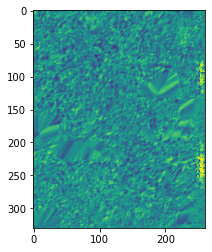

In [10]:
nz=20
input_z_t=torch.randn(10,nz*2)
input_z_t=input_z_t.view(-1,nz,2,1)
plt.imshow(G_test(input_z_t)[0][0].detach().numpy())